In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


In [2]:
# Charger le dataset original
df = pd.read_csv("Concrete_Data.csv")

print("Dataset chargé :", df.shape)
df.head()


Dataset chargé : (1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
def add_noise_features(df, n_noise=200):
    for i in range(n_noise):
        df[f"noise_{i}"] = np.random.normal(0, 1, size=df.shape[0])
    return df

df = add_noise_features(df, n_noise=200)
print("Nouveau shape :", df.shape)


Nouveau shape : (1030, 209)


/tmp/ipython-input-778067555.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"noise_{i}"] = np.random.normal(0, 1, size=df.shape[0])
/tmp/ipython-input-778067555.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"noise_{i}"] = np.random.normal(0, 1, size=df.shape[0])
/tmp/ipython-input-778067555.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [7]:
# Trouver automatiquement le nom de colonne qui contient "compressive"
target_col = [c for c in df.columns if "compressive" in c.lower()][0]

print("Target column detected :", target_col)

X = df.drop(columns=[target_col])
y = df[target_col]


Target column detected : Concrete compressive strength(MPa, megapascals) 


In [8]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

rf_importance = rf.feature_importances_


In [9]:
et = ExtraTreesRegressor(n_estimators=500, random_state=42)
et.fit(X, y)

et_importance = et.feature_importances_


In [11]:
def RLT_proxy(X, y, n_trees=300, max_depth=4):
    n_features = X.shape[1]
    importance = np.zeros(n_features)
    X_np = X.values if isinstance(X, pd.DataFrame) else X

    for t in range(n_trees):
        subset = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X_np[:, subset], y)
        importance[subset] += tree.feature_importances_
    return importance
rlt_importance = RLT_proxy(X, y)


In [12]:
df_importances = pd.DataFrame({
    "Variable": X.columns,
    "RF": rf_importance,
    "ExtraTrees": et_importance,
    "RLT": rlt_importance
})

df_importances.head(20)


,Variable,RF,ExtraTrees,RLT
0,Cement (component 1)(kg in a m^3 mixture),0.298291,0.225970,16.432220
1,Blast Furnace Slag (component 2)(kg in a m^3 m...,0.062964,0.068309,9.829735
2,Fly Ash (component 3)(kg in a m^3 mixture),0.008030,0.030373,6.656889
3,Water (component 4)(kg in a m^3 mixture),0.084254,0.065988,9.998530
4,Superplasticizer (component 5)(kg in a m^3 mix...,0.054373,0.078862,10.454933
5,Coarse Aggregate (component 6)(kg in a m^3 mi...,0.009835,0.011844,12.475024
6,Fine Aggregate (component 7)(kg in a m^3 mixture),0.018204,0.028202,14.159488
7,Age (day),0.312379,0.325794,15.560825
8,noise_0,0.000696,0.000890,1.378216
9,noise_1,0.000355,0.000574,0.833116


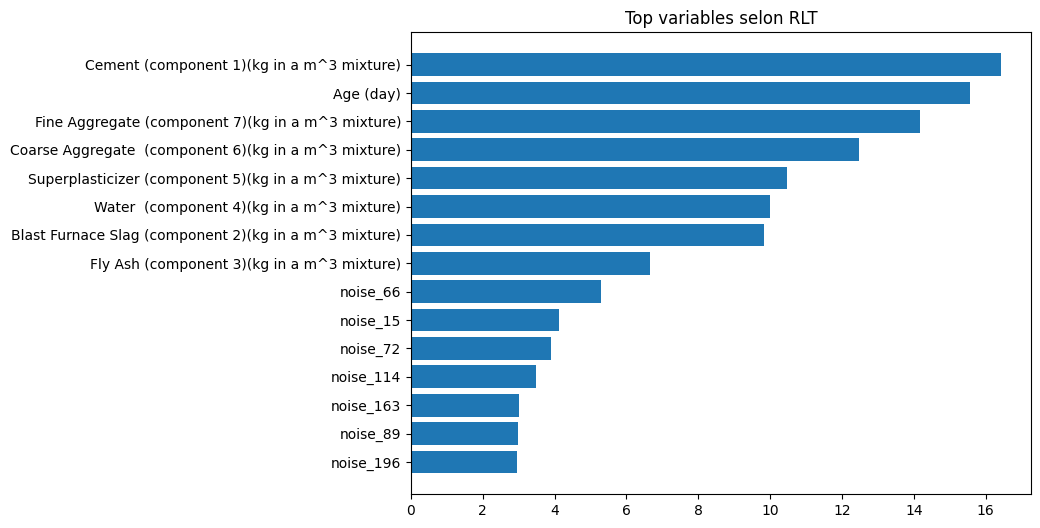

In [13]:
top = df_importances.sort_values("RLT", ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(top["Variable"], top["RLT"])
plt.title("Top variables selon RLT")
plt.gca().invert_yaxis()
plt.show()


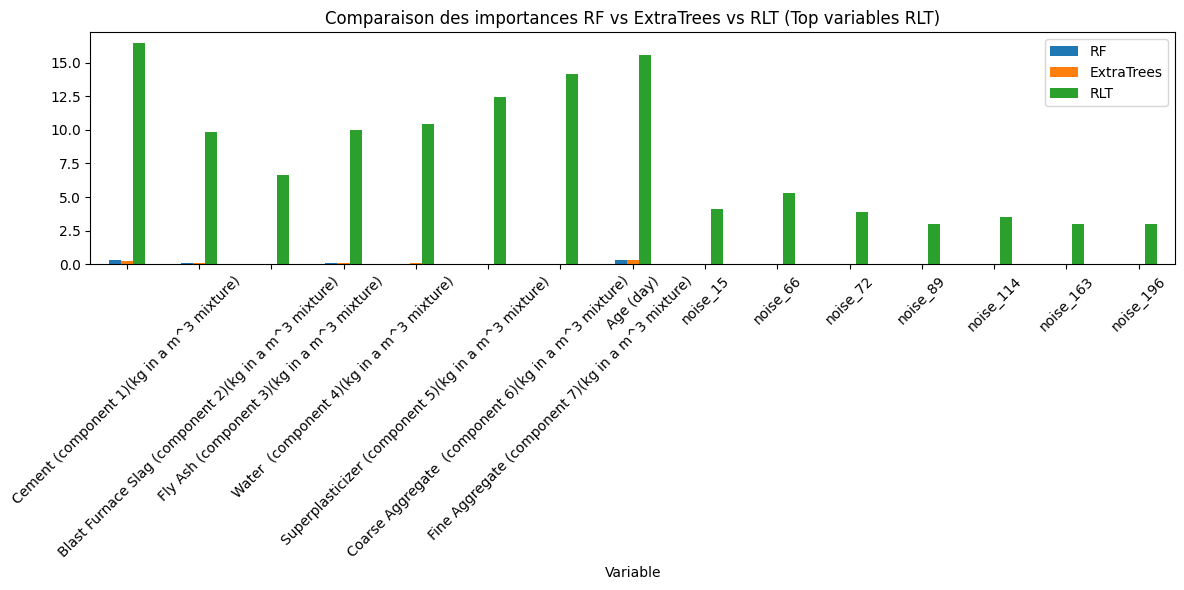

In [15]:
compare_top = df_importances[df_importances["Variable"].isin(top["Variable"])]

compare_top.plot(
    x="Variable",
    y=["RF", "ExtraTrees", "RLT"],
    kind="bar",
    figsize=(12,6)
)

plt.title("Comparaison des importances RF vs ExtraTrees vs RLT (Top variables RLT)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Comparaison_RF_ET_RLT.png", dpi=300)
plt.show()


In [16]:
# Calcul du % de bruit dans le Top 15
nb_noise = sum(top["Variable"].str.contains("noise"))
noise_ratio = nb_noise / len(top) * 100

print(f"Pourcentage de variables bruit dans le Top 15 RLT : {noise_ratio:.2f}%")


Pourcentage de variables bruit dans le Top 15 RLT : 46.67%
